<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h1>2. Machine Learning Probelm </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> 2.1.2 Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Since probabilistic scores of classes are to be considered and log loss is the only performance metric which considers predicted probabilities- it is chosen as the key performance index

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

<h2> 2.3 Train and Test Construction </h2>

<p>  </p>
<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

<p>Time based splitting would have been the ideal splitting strategy for this problem as questions on quora change with time due to change in opinions, reviews etc. A model trained on time based splitting would have ensured that it will perform well on future questions as well. However, due to the absence of timestamp data for questions, time based splitting is not possible. </p>

<h1>3. Exploratory Data Analysis </h1>

In [270]:
#importing the necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import os
import re #regular expressions
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer #for stemming
from bs4 import BeautifulSoup #to remove html tags

<h2> 3.1 Reading data and basic stats </h2>

In [271]:
df=pd.read_csv("train.csv")
print("shape of dataframe: {}".format(df.shape))
print("number of data points: {}".format(df.shape[0]))
print("number of original columns/features: {}".format(df.shape[1]))

shape of dataframe: (404290, 6)
number of data points: 404290
number of original columns/features: 6


<b>I am taking 1/5th data of the total sample due to time contraints </b>

In [272]:
df=df.sample(frac=0.2, replace=True, random_state=1)

In [273]:
print("shape of dataframe: {}".format(df.shape))
print("number of data points: {}".format(df.shape[0]))
print("number of original columns/features: {}".format(df.shape[1]))

shape of dataframe: (80858, 6)
number of data points: 80858
number of original columns/features: 6


In [274]:
df.head()

id    qid1    qid2  \
128037  128037  205994  205995   
267336  267336  182458  171636   
312201  312201  436610  436611   
371403  371403  502028  502029   
73349    73349  125868  125869   

                                                question1  \
128037  What is the best strategy for the Netherlands ...   
267336  What are some of the most amazing photographs ...   
312201                       Effect of braces on hearing?   
371403  If someone asks if you are intelligent, what's...   
73349   Why is the script in unity not allowing me to ...   

                                                question2  is_duplicate  
128037  What is the best strategy for Argentina to def...             0  
267336  What is the most amazing photograph you have e...             0  
312201             Are there any after effects of braces?             0  
371403  How will you answer if someone asks if you're ...             1  
73349               Is my waist unusually wide for a man?             0

In [275]:
#to get a summary of the dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80858 entries, 128037 to 351111
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            80858 non-null  int64 
 1   qid1          80858 non-null  int64 
 2   qid2          80858 non-null  int64 
 3   question1     80858 non-null  object
 4   question2     80858 non-null  object
 5   is_duplicate  80858 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 4.3+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

<h3> 3.2.1 Distribution of data points among output classes</h3>
- Number of duplicate(similar) and non-duplicate(non similar) questions

In [276]:
df.shape

(80858, 6)

In [277]:
df["is_duplicate"].value_counts()

0    51041
1    29817
Name: is_duplicate, dtype: int64

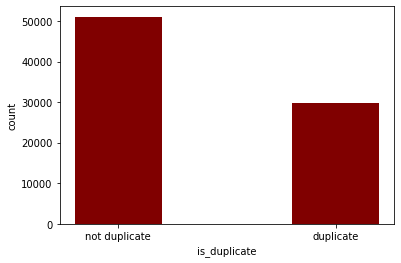

In [278]:
label=["not duplicate", "duplicate"] #takes the class label
label_count=[] #takes the number of values corresponding to the class label
g=df.groupby("is_duplicate")
for group, group_df in g:
    label_count.append(len(group_df))
plt.bar(label,label_count, color="maroon", width=0.4)
plt.xlabel("is_duplicate")
plt.ylabel("count")
plt.show()

In [279]:
print("percentage of question pairs which are not similar/duplicate: {}".format(round((label_count[0]/len(df)*100))))
print("percentage of question pairs which are similar/duplicate: {}".format(round((label_count[1]/len(df)*100))))


percentage of question pairs which are not similar/duplicate: 63
percentage of question pairs which are similar/duplicate: 37


<h3> 3.2.2 Number of unique questions </h3>

<b>we can see that there are 80858 rows meaning 80858 pairs of questions, if all the questions are unique </b>
<b>then there will be 80858*2=161716 unique questions in the data </b>

In [280]:
l1=df["qid1"].tolist()+df["qid2"].tolist() #list of question id
l2=df["question1"].tolist()+df["question2"].tolist() #list of text 
dic_id_text=dict(zip(l1,l2)) #this dictionary has question id as key and text as value
print("number of unique questions: {}".format(len(dic_id_text)))

number of unique questions: 125751


In [281]:
#now we want to crate a dictionary with qid as key and no of times question is repeated as value
from tqdm import tqdm
qid=[]
qid_count=[]
for question in tqdm(dic_id_text.keys()):
    qid.append(question)
    qid_count.append(l1.count(question))
dic_id_count=dict(zip(qid,qid_count)) #this dictionary has question id as key and occurences as value

100%|█████████████████████████████████████████████████████████████████████████| 125751/125751 [04:58<00:00, 421.30it/s]


In [282]:
count_more_than_1=0
count_one=0
for frequency in dic_id_count.values():
    if(frequency==1):
        count_one+=1
    else:
        count_more_than_1+=1
print("number of questions that occur more than 1 time : {}".format(count_more_than_1)) 
print("number of questions that occur only 1 time : {}".format(count_one))

#you can see that the sum of number of questions that occur one time and number of questions that occur more than 1 time is equal to the total number of unique question

print("max number of times a single question is repeated: {}".format(max(dic_id_count.values())))

number of questions that occur more than 1 time : 23764
number of questions that occur only 1 time : 101987
max number of times a single question is repeated: 30


<h3>3.2.3 Checking for NULL values </h3>

In [283]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80858 entries, 128037 to 351111
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            80858 non-null  int64 
 1   qid1          80858 non-null  int64 
 2   qid2          80858 non-null  int64 
 3   question1     80858 non-null  object
 4   question2     80858 non-null  object
 5   is_duplicate  80858 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 4.3+ MB


In [284]:
print("all the values are non null, if there were null values in question text we would have replaced them with a text containing of only space")

all the values are non null, if there were null values in question text we would have replaced them with a text containing of only space


<h2> 4. Preprocessing of Text-Data Cleaning </h2>

<b>Text Preprocessing</b>

<b> All the fucntions have been taken from the Amazon Fine Food Review Notebook </b>

Now that we have finished loading and cleaning, our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Remove all the url
2. Begin by removing the html tags
3. Remove any punctuations or limited set of special characters like , or . or # etc.
4. Check if the word is made up of english letters and is not alpha-numeric
5. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
6. Convert the word to lowercase
7. Remove Stopwords
8. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)

<h3> 4.1. Defining Functions for cleaning </h3>

In [285]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
import re
def remove_url(sentence):
    sentence=re.sub(r"http\S+","",sentence)
    return sentence
#starts with http followed by one or more non space characters till the next space occurs
#raw string for re pattern as python takes \t as tab which is considered as something else in regular expression context

In [286]:
def random(sentence):
    sentence=re.sub(r"%", " percent ",sentence)
    sentence=re.sub(r"₹", " rupee ",sentence)
    sentence=re.sub(r"$", " dollar ",sentence)
    sentence=re.sub(r"€", " euro ",sentence)
    sentence=re.sub(r"([0-9]+)000000", r"\1m",sentence)
    sentence=re.sub(r"([0-9]+)000", r"\1k",sentence)
    return sentence

In [287]:
#removing html tags-sample
from bs4 import BeautifulSoup
str="<html> hello my name <br />is mahavir dabas </html>"
str=BeautifulSoup(str,'lxml')
str=str.get_text()
print(str)

 hello my name is mahavir dabas 


In [288]:
def remove_html_tag(sentence):
    sentence=BeautifulSoup(sentence,'lxml').get_text()
    return sentence

In [289]:
#try to decontract as many words as possible
def decontracted(sentence):
    # specific
    sentence = re.sub(r"won\'t", "will not", sentence)
    sentence = re.sub(r"can\'t", "can not", sentence)

    # general
    sentence = re.sub(r"n\'t", " not", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'s", " is", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'t", " not", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'m", " am", sentence)
    return sentence


In [290]:
def remove_alpha_numeric(sentence): #words with numbers as well
    sentence=re.sub(r"\S*\d+\S*","",sentence)
    return sentence
#zero or more non space followed by one or more digits followed by zero or more non space

In [291]:
def remove_special_char(sentence): # @ # $ % ^ & <  etc
    sentence=re.sub(r"[^a-zA-Z\S]+"," ",sentence)
    return sentence
#not a-z or A-Z or white space- 1 or more such occurences-we will replace them with a space

In [292]:
def remove_punctuations(sentence):
    sentence=re.sub(r"[^\w\s]"," ",sentence)
    return sentence
#not (word char or space char)- it has to be a punctuation if you have removed alpha numeric, html tags, url, and special char
#therefore use it in the end- the function has been designed on this assumption that it will be used at lastb

In [293]:
def remove_underscore(sentence):
    sentence=re.sub(r"_+","",sentence)
    return sentence

<h3> 4.2. Performing Data Cleaning </h3>


In [294]:
clean_text=[] #list to store all the final preprocessed texts

for sentence in tqdm(dic_id_text.values()):
    #.strip() removes all the trailing and leading characters (by default-white space) from a string
    #using all the functions made for preprocessing
    sentence=remove_url(sentence).strip()
    sentence=remove_html_tag(sentence).strip()
    sentence=decontracted(sentence).strip()
    sentence=remove_alpha_numeric(sentence).strip()
    sentence=remove_special_char(sentence).strip()
    sentence=remove_punctuations(sentence).strip() #used in the end
    sentence=remove_underscore(sentence).strip()
      
    #converting words to lower case 
    word_list=sentence.split() #splits the string by white spaces and stores it in a list
    word_list=[i.lower() for i in word_list] #changing case of all words to lower case
    sentence=" ".join(word_list) #sentence has been created from all the final words in word_list
    sentence.strip()
    clean_text.append(sentence)

100%|████████████████████████████████████████████████████████████████████████| 125751/125751 [00:48<00:00, 2589.76it/s]


<b>Note- We haven't removed stopwords now as we would be using them as features</b>

<b>We will remove them before converting text to vectors</b>

In [295]:
print("some samples of clean text: \n")
for i in range(5):
    print(clean_text[i])

some samples of clean text: 

what is the best strategy for the netherlands to defeat argentina in the world cup semifinal match
what are some of the most amazing photographs ever taken
effect of braces on hearing
if someone asks if you are intelligent what is the best way to answer without sounding conceited
why is the script in unity not allowing me to edit it


In [296]:
#l1 is the list of unique question id
#clean_text is the list of clean texts corresponding to the question id
#we are updating the dict of qid and text with clean text

dic_id_text=dict(zip(l1,clean_text)) #this dictionary has question id as key and text as value

<h2> 5. Basic Feature Extraction </h2>

<h3> 5.1 Extraction </h3>

Constructing a few basic features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = string Length of q1
 - ____q2len____ = string Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [297]:
freq_qid1=[]
freq_qid2=[]
q1len=[] 
q2len=[]
q1_n_words=[]
q2_n_words=[]
word_common=[]
word_total=[]
word_share=[]
freq_sum=[]
freq_diff=[]
for i in tqdm(range(len(df))):
    freq1=dic_id_count[df.iloc[i]["qid1"]]
    freq2=dic_id_count[df.iloc[i]["qid2"]]
    freq_qid1.append(freq1) #f1
    freq_qid2.append(freq2) #f2
    freq_sum.append(freq1+freq2) #f3
    freq_diff.append(abs(freq1-freq2)) #f4
    str1=df.iloc[i]["question1"] #text question 1
    str2=df.iloc[i]["question2"] #text question 2
    token1=str1.split() #tokens question 1
    token2=str2.split() #tokens question 2
    q1len.append(len(str1)) #f5
    q2len.append(len(str2)) #f6
    q1_n_words.append(len(token1)) #f7
    q2_n_words.append(len(token2)) #f8
    total_words=len(token1)+len(token2) #total words in both ques
    common_words=len(set(token1) & set(token2))
    word_total.append(total_words) #f9
    word_common.append(common_words) #f10
    word_share.append(common_words/(total_words+pow(10,-9))) #f11

100%|██████████████████████████████████████████████████████████████████████████| 80858/80858 [00:48<00:00, 1658.04it/s]


In [298]:
#adding the new features to the dataframe
df["freq_qid1"]=pd.Series(freq_qid1).values
df["freq_qid2"]=pd.Series(freq_qid2).values
df["q1len"]=pd.Series(q1len).values
df["q2len"]=pd.Series(q2len).values
df["q1_n_words"]=pd.Series(q1_n_words).values
df["q2_n_words"]=pd.Series(q2_n_words).values
df["word_common"]=pd.Series(word_common).values
df["word_total"]=pd.Series(word_total).values
df["word_share"]=pd.Series(word_share).values
df["freq_sum"]=pd.Series(freq_sum).values
df["freq_diff"]=pd.Series(freq_diff).values

In [299]:
df.head()

id    qid1    qid2  \
128037  128037  205994  205995   
267336  267336  182458  171636   
312201  312201  436610  436611   
371403  371403  502028  502029   
73349    73349  125868  125869   

                                                question1  \
128037  What is the best strategy for the Netherlands ...   
267336  What are some of the most amazing photographs ...   
312201                       Effect of braces on hearing?   
371403  If someone asks if you are intelligent, what's...   
73349   Why is the script in unity not allowing me to ...   

                                                question2  is_duplicate  \
128037  What is the best strategy for Argentina to def...             0   
267336  What is the most amazing photograph you have e...             0   
312201             Are there any after effects of braces?             0   
371403  How will you answer if someone asks if you're ...             1   
73349               Is my waist unusually wide for a man?             0   

        freq_qid1  freq_qid2  q1len  q2len  q1_n_words  q2_n_words  \
128037          1          1    104    104          18          18   
267336          2          1     57     65          10          12   
312201          1          1     28     38           5           7   
371403          3          3     97     58          16          10   
73349           2          2     54     37          12           8   

        word_common  word_total  word_share  freq_sum  freq_diff  
128037           16          36    0.444444         2          0  
267336            5          22    0.227273         3          1  
312201            1          12    0.083333         2          0  
371403            5          26    0.192308         6          0  
73349             0          20    0.000000         4          0

<h3> 5.2 Analysis of some of the basic extracted features </h3>

<p> word_share and word_common seem to be important features, so let's perform basic eda on these 2 features <p>

<h4> 5.2.1 Feature: word_share </h4>

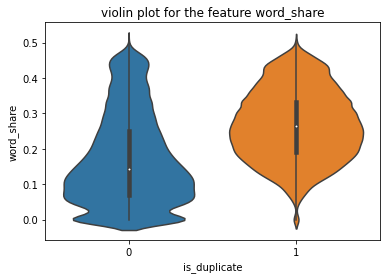

In [37]:
sns.violinplot(x="is_duplicate",y="word_share",data=df)
plt.title("violin plot for the feature word_share")
plt.show()

- The average word share of qid1 and qid2 is more when they are duplicate(Similar)

<h4> 5.2.1 Feature: word_common </h4>

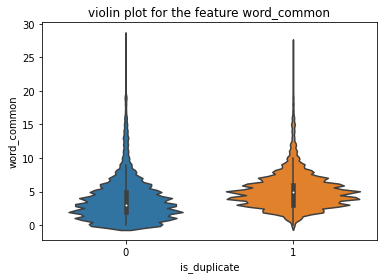

In [54]:
sns.violinplot(x="is_duplicate",y="word_common",data=df)
plt.title("violin plot for the feature word_common")
plt.show()

- The distributions of the word_Common feature in similar and non-similar questions are highly overlapping

<h2> 6. Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


<h3> 6.1 Feature Extraction  </h3>

In [300]:
from fuzzywuzzy import fuzz
import nltk
from nltk.corpus import stopwords
from difflib import SequenceMatcher

cwc_min=[]
cwc_max=[]
csc_min=[] 
csc_max=[]
ctc_min=[]
ctc_max=[]
last_word_eq=[]
first_word_eq=[]
abs_len_diff=[]
mean_len=[]
fuzz_ratio_val=[]
fuzz_partial_ratio_val=[]
token_sort_ratio_val=[]
token_set_ratio_val=[]
longest_substring_ratio=[]

for i in tqdm(range(len(df))):
    str1=df.iloc[i]["question1"] #text question 1
    str2=df.iloc[i]["question2"] #text question 2
    
    token1=str1.split() #tokens question 1
    token2=str2.split() #tokens question 2
    
    stop_word_1=[token for token in token1 if token in stopwords.words('english')] #stop words in q1
    stop_word_2=[token for token in token2 if token in stopwords.words('english')] #stop words in q2
    
    word1=[token for token in token1 if token not in stopwords.words('english')] #words in q1
    word2=[token for token in token2 if token not in stopwords.words('english')] #words in q2
    
    cwc_min.append(len(set(word1) & set(word2))/(pow(10,-4)+min(len(word1),len(word2)))) #f12
    cwc_max.append(len(set(word1) & set(word2))/(pow(10,-4)+max(len(word1),len(word2)))) #f13
    csc_min.append(len(set(stop_word_1) & set(stop_word_2))/(pow(10,-4)+min(len(word1),len(word2)))) #f14
    csc_max.append(len(set(stop_word_1) & set(stop_word_2))/(pow(10,-4)+max(len(word1),len(word2)))) #f15
    ctc_min.append(len(set(token1) & set(token2))/(pow(10,-4)+min(len(word1),len(word2)))) #f16
    ctc_max.append(len(set(token1) & set(token2))/(pow(10,-4)+max(len(word1),len(word2)))) #f17
    
    if(len(word1)!=0 and len(word2)!=0 and word1[-1]==word2[-1]): #f18
        last_word_eq.append(1)
    else:
        last_word_eq.append(0)
        
    if(len(word1)!=0 and len(word2)!=0 and word1[0]==word2[0]): #f19
        first_word_eq.append(1)
    else:
        first_word_eq.append(0)
    
    abs_len_diff.append(abs(len(token1)-len(token2))) #f20
    mean_len.append((len(token1)+len(token2))/2) #f21
    
    match = SequenceMatcher(None, str1, str2).find_longest_match(0, len(str1), 0, len(str2))
    longest_common=str1[match.a: match.a + match.size]
    longest_substring_ratio.append(len(longest_common)/(pow(10,-4)+min(len(token1),len(token2)))) #f22
    
    fuzz_ratio_val.append(fuzz.ratio(str1,str2)) #f23
    fuzz_partial_ratio_val.append(fuzz.partial_ratio(str1,str2)) #f24
    token_sort_ratio_val.append(fuzz.token_sort_ratio(str1,str2)) #f25
    token_set_ratio_val.append(fuzz.token_set_ratio(str1,str2)) #f26

100%|████████████████████████████████████████████████████████████████████████████| 80858/80858 [14:55<00:00, 90.26it/s]


In [301]:
len(cwc_min)

80858

In [302]:
len(cwc_max)

80858

In [303]:
token_set_ratio_val[2]

62

In [304]:
#adding the new features

df["cwc_min"]=pd.Series(cwc_min).values
df["cwc_max"]=pd.Series(cwc_max).values
df["csc_min"]=pd.Series(csc_min).values
df["csc_max"]=pd.Series(csc_max).values
df["ctc_min"]=pd.Series(ctc_min).values
df["ctc_max"]=pd.Series(ctc_max).values
df["last_word_eq"]=pd.Series(last_word_eq).values
df["first_word_eq"]=pd.Series(first_word_eq).values
df["abs_len_diff"]=pd.Series(abs_len_diff).values
df["mean_len"]=pd.Series(mean_len).values
df["fuzz_ratio_val"]=pd.Series(fuzz_ratio_val).values
df["fuzz_partial_ratio_val"]=pd.Series(fuzz_partial_ratio_val).values
df["token_sort_ratio_val"]=pd.Series(token_sort_ratio_val).values
df["token_set_ratio_val"]=pd.Series(token_set_ratio_val).values
df["longest_substring_ratio"]=pd.Series(longest_substring_ratio).values

In [305]:
df.head()

id    qid1    qid2  \
128037  128037  205994  205995   
267336  267336  182458  171636   
312201  312201  436610  436611   
371403  371403  502028  502029   
73349    73349  125868  125869   

                                                question1  \
128037  What is the best strategy for the Netherlands ...   
267336  What are some of the most amazing photographs ...   
312201                       Effect of braces on hearing?   
371403  If someone asks if you are intelligent, what's...   
73349   Why is the script in unity not allowing me to ...   

                                                question2  is_duplicate  \
128037  What is the best strategy for Argentina to def...             0   
267336  What is the most amazing photograph you have e...             0   
312201             Are there any after effects of braces?             0   
371403  How will you answer if someone asks if you're ...             1   
73349               Is my waist unusually wide for a man?             0   

        freq_qid1  freq_qid2  q1len  q2len  ...   ctc_max  last_word_eq  \
128037          1          1    104    104  ...  1.454532             1   
267336          2          1     57     65  ...  0.833319             0   
312201          1          1     28     38  ...  0.333322             0   
371403          3          3     97     58  ...  0.454541             0   
73349           2          2     54     37  ...  0.000000             0   

        first_word_eq  abs_len_diff  mean_len  fuzz_ratio_val  \
128037              1             0      18.0              83   
267336              1             2      11.0              75   
312201              0             2       6.0              48   
371403              0             6      13.0              46   
73349               0             4      10.0              42   

        fuzz_partial_ratio_val  token_sort_ratio_val  token_set_ratio_val  \
128037                      83                   100                  100   
267336                      79                    72                   82   
312201                      58                    53                   62   
371403                      57                    66                   86   
73349                       46                    36                   38   

        longest_substring_ratio  
128037                 2.166655  
267336                 2.799972  
312201                 1.999960  
371403                 2.099979  
73349                  0.374995  

[5 rows x 32 columns]

<h3> 6.2 Pair Plots of ctc_min,cwc_min,csc_min,token_sort_ratio_val  </h3>

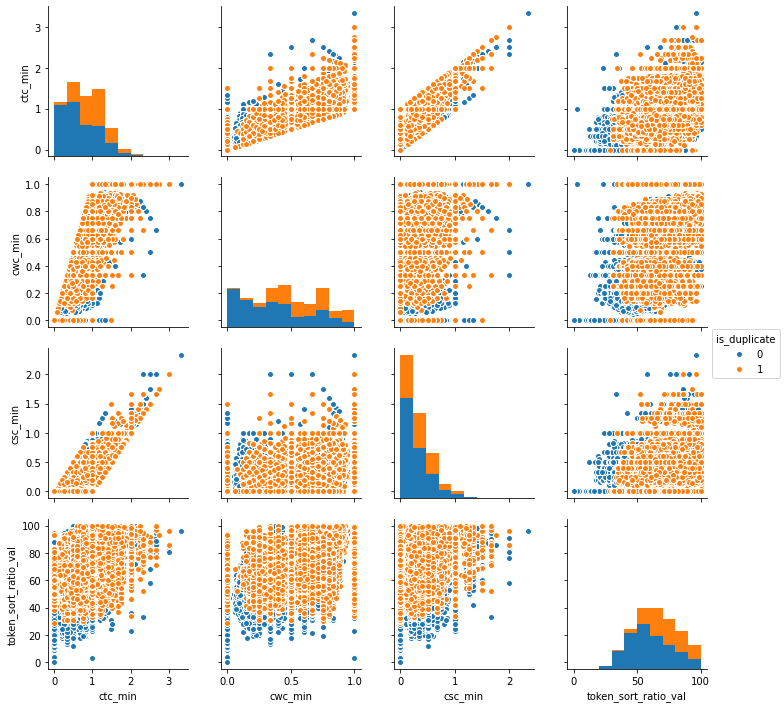

In [127]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio_val', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio_val'])
plt.show()

<h3> 6.3 Violin Plots of some of the newly extracted features  </h3>

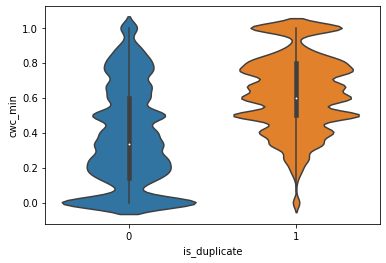

In [130]:
sns.violinplot(x="is_duplicate",y="cwc_min",data=df)
plt.show()

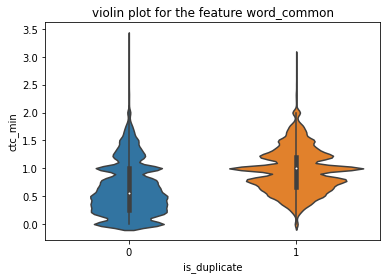

In [131]:
sns.violinplot(x="is_duplicate",y="ctc_min",data=df)
plt.show()

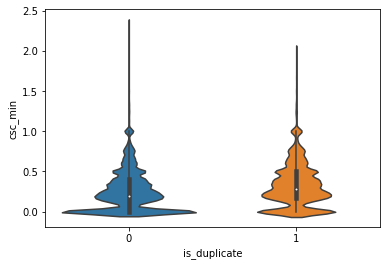

In [132]:
sns.violinplot(x="is_duplicate",y="csc_min",data=df)
plt.show()

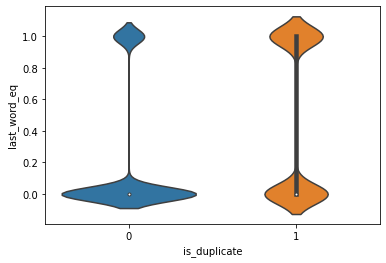

In [133]:
sns.violinplot(x="is_duplicate",y="last_word_eq",data=df)
plt.show()

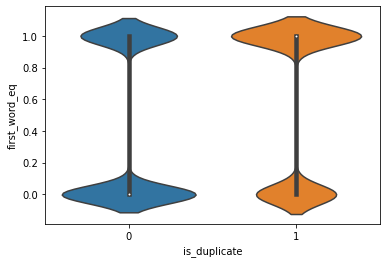

In [134]:
sns.violinplot(x="is_duplicate",y="first_word_eq",data=df)
plt.show()

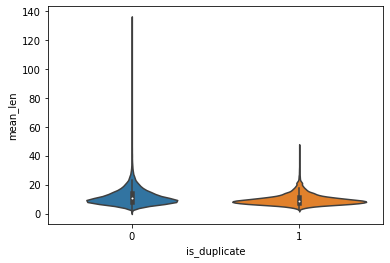

In [135]:
sns.violinplot(x="is_duplicate",y="mean_len",data=df)
plt.show()

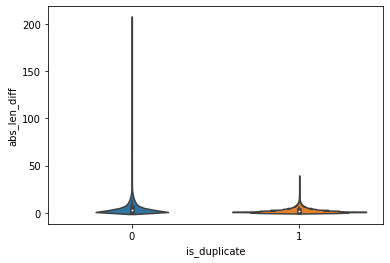

In [136]:
sns.violinplot(x="is_duplicate",y="abs_len_diff",data=df)
plt.show()

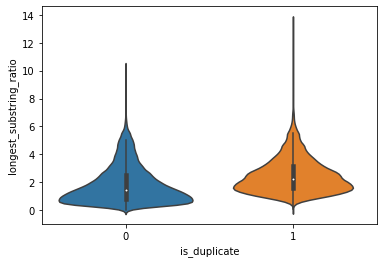

In [137]:
sns.violinplot(x="is_duplicate",y="longest_substring_ratio",data=df)
plt.show()

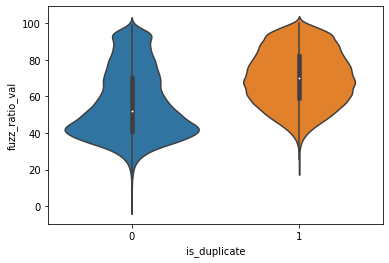

In [139]:
sns.violinplot(x="is_duplicate",y="fuzz_ratio_val",data=df)
plt.show()

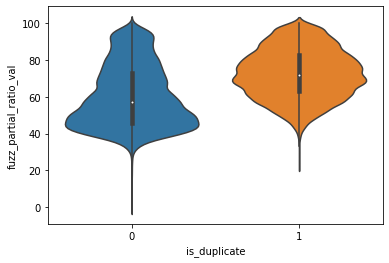

In [140]:
sns.violinplot(x="is_duplicate",y="fuzz_partial_ratio_val",data=df)
plt.show()

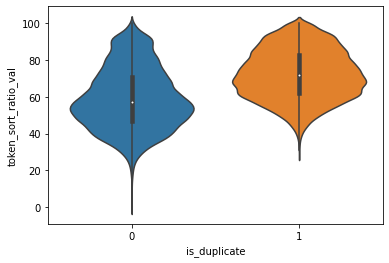

In [141]:
sns.violinplot(x="is_duplicate",y="token_sort_ratio_val",data=df)
plt.show()

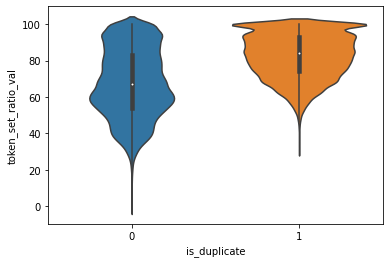

In [142]:
sns.violinplot(x="is_duplicate",y="token_set_ratio_val",data=df)
plt.show()

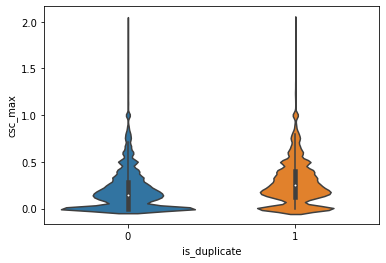

In [143]:
sns.violinplot(x="is_duplicate",y="csc_max",data=df)
plt.show()

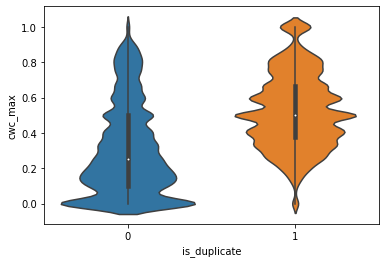

In [144]:
sns.violinplot(x="is_duplicate",y="cwc_max",data=df)
plt.show()

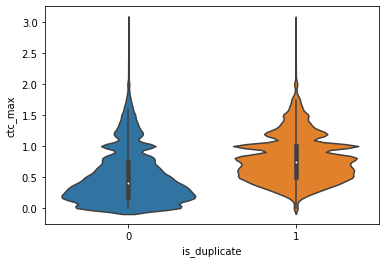

In [145]:
sns.violinplot(x="is_duplicate",y="ctc_max",data=df)
plt.show()

<b> Observations- The following features are able to give some partial separation bw the classes </b>
- cwc min 
- cwc max
- ctc min
- ctc max
- longest substring ratio
- fuzz ratio
- fuzz partial ratio
- token sort ratio
- token set ratio

<h2> 7. Visualisation of all features using TSNE </h2>

<p> We have seen pair plots of some of the features, but to get an idea of how well all my features perform in separating the classes, let's plot a 2-dimensional plot by embedding all the 15 new numerical features in a 2d plane </p> 

<h3> 7.1 DataFrame Modifications </h3>

<p> First making some changes to the dataframe </p>

In [310]:
#resetting the index
df=df.reset_index()
df.head()

index      id    qid1    qid2  \
0      0  128037  205994  205995   
1      1  267336  182458  171636   
2      2  312201  436610  436611   
3      3  371403  502028  502029   
4      4   73349  125868  125869   

                                           question1  \
0  What is the best strategy for the Netherlands ...   
1  What are some of the most amazing photographs ...   
2                       Effect of braces on hearing?   
3  If someone asks if you are intelligent, what's...   
4  Why is the script in unity not allowing me to ...   

                                           question2  is_duplicate  freq_qid1  \
0  What is the best strategy for Argentina to def...             0          1   
1  What is the most amazing photograph you have e...             0          2   
2             Are there any after effects of braces?             0          1   
3  How will you answer if someone asks if you're ...             1          3   
4              Is my waist unusually wide for a man?             0          2   

   freq_qid2  q1len  ...   ctc_max  last_word_eq  first_word_eq  abs_len_diff  \
0          1    104  ...  1.454532             1              1             0   
1          1     57  ...  0.833319             0              1             2   
2          1     28  ...  0.333322             0              0             2   
3          3     97  ...  0.454541             0              0             6   
4          2     54  ...  0.000000             0              0             4   

   mean_len  fuzz_ratio_val  fuzz_partial_ratio_val  token_sort_ratio_val  \
0      18.0              83                      83                   100   
1      11.0              75                      79                    72   
2       6.0              48                      58                    53   
3      13.0              46                      57                    66   
4      10.0              42                      46                    36   

   token_set_ratio_val  longest_substring_ratio  
0                  100                 2.166655  
1                   82                 2.799972  
2                   62                 1.999960  
3                   86                 2.099979  
4                   38                 0.374995  

[5 rows x 33 columns]

In [312]:
#dropping the id column 
df.drop('id', inplace=True, axis=1)
df.head()

qid1    qid2                                          question1  \
0  205994  205995  What is the best strategy for the Netherlands ...   
1  182458  171636  What are some of the most amazing photographs ...   
2  436610  436611                       Effect of braces on hearing?   
3  502028  502029  If someone asks if you are intelligent, what's...   
4  125868  125869  Why is the script in unity not allowing me to ...   

                                           question2  is_duplicate  freq_qid1  \
0  What is the best strategy for Argentina to def...             0          1   
1  What is the most amazing photograph you have e...             0          2   
2             Are there any after effects of braces?             0          1   
3  How will you answer if someone asks if you're ...             1          3   
4              Is my waist unusually wide for a man?             0          2   

   freq_qid2  q1len  q2len  q1_n_words  ...   ctc_max  last_word_eq  \
0          1    104    104          18  ...  1.454532             1   
1          1     57     65          10  ...  0.833319             0   
2          1     28     38           5  ...  0.333322             0   
3          3     97     58          16  ...  0.454541             0   
4          2     54     37          12  ...  0.000000             0   

   first_word_eq  abs_len_diff  mean_len  fuzz_ratio_val  \
0              1             0      18.0              83   
1              1             2      11.0              75   
2              0             2       6.0              48   
3              0             6      13.0              46   
4              0             4      10.0              42   

   fuzz_partial_ratio_val  token_sort_ratio_val  token_set_ratio_val  \
0                      83                   100                  100   
1                      79                    72                   82   
2                      58                    53                   62   
3                      57                    66                   86   
4                      46                    36                   38   

   longest_substring_ratio  
0                 2.166655  
1                 2.799972  
2                 1.999960  
3                 2.099979  
4                 0.374995  

[5 rows x 31 columns]

In [313]:
#separating the class label from the dataframe
is_duplicate=df["is_duplicate"]
is_duplicate

0        0
1        0
2        0
3        1
4        0
        ..
80853    0
80854    1
80855    1
80856    1
80857    0
Name: is_duplicate, Length: 80858, dtype: int64

In [314]:
#dropping the class label from the dataframe
df.drop('is_duplicate', inplace=True, axis=1)

In [315]:
print("the shape of the final dataframe: {}".format(df.shape))
print("-"*50)
print(df.head())

the shape of the final dataframe: (80858, 30)
--------------------------------------------------
     qid1    qid2                                          question1  \
0  205994  205995  What is the best strategy for the Netherlands ...   
1  182458  171636  What are some of the most amazing photographs ...   
2  436610  436611                       Effect of braces on hearing?   
3  502028  502029  If someone asks if you are intelligent, what's...   
4  125868  125869  Why is the script in unity not allowing me to ...   

                                           question2  freq_qid1  freq_qid2  \
0  What is the best strategy for Argentina to def...          1          1   
1  What is the most amazing photograph you have e...          2          1   
2             Are there any after effects of braces?          1          1   
3  How will you answer if someone asks if you're ...          3          3   
4              Is my waist unusually wide for a man?          2          2   

 

<p>- we have our 30 features in the dataframe </p>
<p>- the class label has been stored in the is_duplicate pandas series</p>

<h3> 7.2 Applying T-SNE </h3>

<h4> 7.2.1 Data Preprocessing: Standardising the Data-Min Max Scaler </h4>

<p> NOTE- we are taking only the top 5k rows for visualisation with TSNE as taking 80k points will take a lot of time <p/>

In [172]:
from sklearn.preprocessing import StandardScaler

#taking the sample
df_subsample=df[['cwc_min',
       'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq',
       'first_word_eq', 'abs_len_diff', 'mean_len', 'fuzz_ratio_val',
       'fuzz_partial_ratio_val', 'token_sort_ratio_val', 'token_set_ratio_val',
       'longest_substring_ratio']]
df_subsample=df_subsample[0:5000]
is_duplicate_subsample=is_duplicate[0:5000]

#applying the scaling technique
df_subsample = StandardScaler().fit_transform(df_subsample)
print(df_subsample.shape)
print(is_duplicate_subsample.shape)

(5000, 15)
(5000,)


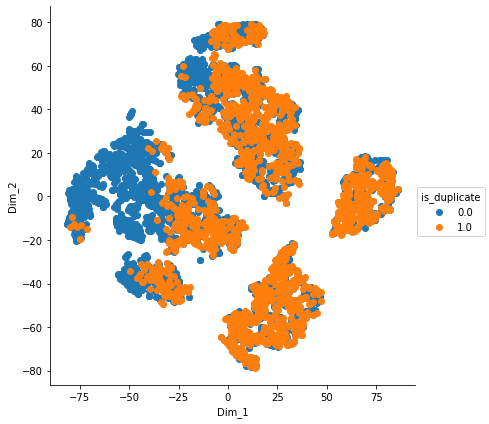

In [178]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2-- the final number of dimensions
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(df_subsample)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, is_duplicate_subsample)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "is_duplicate"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="is_duplicate", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

In [180]:
from sklearn.manifold import TSNE

model = TSNE(n_components=3, random_state=0)
# configuring the parameteres
# the number of components = 2-- the final number of dimensions
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(df_subsample)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, is_duplicate_subsample)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","Dim_3" ,"is_duplicate"))

# Ploting the result of tsne 3d
import plotly.express as px
fig=px.scatter_3d(data_frame=tsne_df,x="Dim_1",y="Dim_2",z="Dim_3",color="is_duplicate")
fig.show()


<b> NOTE-our features are doing a decent job of partially separating the data <b>

<h2> 8.TF-IDF Weighted Glove Features </h2>

<p> we will be adding the tf-idf weighted glove vectors of both the texts as dimensions as well </p>
<p> glove vectors preserve semantic meanings, the glove vectors used in this notebook will return a 200-dim vector for each word <p/>

https://medium.com/analytics-vidhya/basics-of-using-pre-trained-glove-vectors-in-python-d38905f356db
    
this is the blog for getting the word vectors for each word using glove, it gives a 200 dim vector for each word

use code in this notebook only as there are  slight changes

we are using a pretrained model to get vectors and we won't train it on our corpus 

<h3> 8.1 Glove Features </h3>

In [184]:
embeddings_dict = {}
with open("glove.6B.200d.txt", 'r',encoding="utf8") as f: #this encoding utf-8 was missing in the original code
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

400000it [00:20, 19068.04it/s]


In [185]:
print(len(embeddings_dict["hello"]))

200


In [186]:
print(embeddings_dict["hello"])

[ 0.26609    0.21821   -0.10996   -0.48408   -0.11181   -0.09882
 -0.45315    0.44198   -0.034614   0.10541   -0.29537   -0.10881
  0.20916    0.52484   -0.17985   -0.31187   -0.25724    0.65267
  0.217      0.86503    0.47239   -0.078582   0.31035   -0.12155
 -0.12502   -0.40418    0.53803   -0.57842   -0.63668   -0.13502
 -0.040484   0.41378   -0.63201   -0.38847   -0.43767   -0.19706
  0.2878     0.36039   -0.032893  -0.20361   -0.34918    0.95923
 -0.51221   -0.19035    0.1567     0.17704    0.55302    0.27636
 -0.13707    0.91361    0.25948   -0.30107    0.48343   -0.046869
 -0.2796    -0.040385  -0.45773    0.2768    -0.14468    0.036539
  0.36018   -0.54939    0.19359   -0.38263   -0.29661   -0.18938
  0.095681   0.46646    0.3366     0.78351    0.49517   -0.82418
  0.34402   -0.50038   -0.71074   -0.25711   -0.36619    0.61746
 -0.31281   -0.042413   0.37915   -0.62383    0.27208    0.32852
 -0.23045   -0.12469    0.29898   -0.22525   -0.27045   -0.4447
 -0.15889    0.20325   -

In [189]:
from scipy import spatial
def find_closest_embeddings(embedding):
    return sorted(embeddings_dict.keys(), key=lambda word: spatial.distance.euclidean(embeddings_dict[word], embedding))

In [190]:
#to print the top 5 closest to embedding word
embedding="hello"
find_closest_embeddings(embeddings_dict[embedding])[:5]

['hello', 'goodbye', 'muddah', 'hey', 'xfff']

<h3> 8.3 Removing Stop Words from clean text </h3>

<p> we hadn't removed the stop words from the clean texts earlier as some of our features were based on it, but we can remove them now when we are finding out the tf-idf weighted w2v </p>

In [214]:
#we have list qid with id 
#we have list clean_text with text with stop words

clean_text_new=[]
for text in tqdm(clean_text):
    tokens=text.split()
    words=[token for token in tokens if token.lower() not in stopwords.words("english")]
    sentence=" ".join(words) #sentence has been created from all the final words in word_list
    sentence.strip()
    clean_text_new.append(sentence)


100%|█████████████████████████████████████████████████████████████████████████| 125751/125751 [05:24<00:00, 387.40it/s]


In [218]:
clean_text_new[:5]

['best strategy netherlands defeat argentina world cup semifinal match',
 'amazing photographs ever taken',
 'effect braces hearing',
 'someone asks intelligent best way answer without sounding conceited',
 'script unity allowing edit']

In [219]:
#updating the id:text dict 
print(len(qid))
print(len(clean_text_new))

125751
125751


In [220]:
dic_id_text=dict(zip(qid,clean_text_new))

<h3> 8.4 tfidf-vectorizer </h3>

In [225]:
from sklearn.feature_extraction.text import TfidfVectorizer
#tf-idf is just the same as BOW-instead of occurences we write the product of tf-idf for the word/phrase 
#we will be representing the text as tf-idf vectors
tfidf=TfidfVectorizer(ngram_range=(1,1))
#new tfidf vectoriser model has been created
#ngram_range=(min,max)--by default-(min=1,max=1)- unigrams only
#min_df=10-- only consider terms which have a document frequency of more than 10
#max_features=100000--- only consider the top 100000 features on the basis of their term frequency across the data corpus
x=tfidf.fit_transform(clean_text_new)

In [226]:
print(tfidf.get_feature_names())

['aa', 'aaa', 'aaadhar', 'aachar', 'aachen', 'aad', 'aadhaar', 'aadhar', 'aadmi', 'aage', 'aahat', 'aai', 'aaing', 'aakash', 'aaksh', 'aalto', 'aam', 'aamir', 'aane', 'aanika', 'aantidepressant', 'aanvla', 'aao', 'aap', 'aapl', 'aarathi', 'aardman', 'aaron', 'aaronson', 'aas', 'aashiqui', 'aashish', 'aasra', 'aassange', 'aau', 'aavmc', 'aawad', 'aayiram', 'aayla', 'aayog', 'aa制', 'ab', 'abacus', 'abaddon', 'abaj', 'abandanded', 'abandon', 'abandoned', 'abandons', 'abap', 'abaqus', 'abase', 'abbottabad', 'abbreviation', 'abbreviations', 'abby', 'abc', 'abcd', 'abco', 'abd', 'abdallah', 'abdomen', 'abdominal', 'abduction', 'abdul', 'abdullah', 'abedin', 'abel', 'abercrombie', 'aberdeen', 'aberration', 'abes', 'abf', 'abhimanyu', 'abhinav', 'abhishek', 'abhiyaan', 'abhiyan', 'abhorrent', 'abide', 'abides', 'abids', 'abigail', 'abilities', 'ability', 'abiotic', 'abitur', 'ablation', 'ablaze', 'able', 'abm', 'abn', 'abnormal', 'abnormalities', 'abo', 'aboard', 'abolish', 'abolished', 'aboli

In [229]:
print("no of considered considered as tfidf features: ")
print(len(tfidf.get_feature_names()))

no of considered considered as tfidf features: 
37625


In [231]:
#to check the sparse vector x
print("the type of the sparse matrix containing all the tfidf representarion= ",type(x))
print("the number of unique phrases taken for tfidf representation= ",x.shape[1])
print("the number of texts with tfidf representation= ",x.shape[0])
print("the shape of sparse matrix containing tfidf represenation= ",x.shape)

the type of the sparse matrix containing all the tfidf representarion=  <class 'scipy.sparse.csr.csr_matrix'>
the number of unique phrases taken for tfidf representation=  37625
the number of texts with tfidf representation=  125751
the shape of sparse matrix containing tfidf represenation=  (125751, 37625)


<h3> 8.5 tfidf weighted glove vectors </h3>

In [247]:
idf_dict=dict(zip(tfidf.get_feature_names(), list(tfidf.idf_))) #this dict holds the word and the idf value
tfidf_features = tfidf.get_feature_names()
tfidf_glove=[]
for sentence in tqdm(clean_text_new):
    tokens=sentence.split()
    text_vector=np.zeros(200) #glove returns a 200 dim vector for each word
    total=0
    for word in tokens:
        if word in embeddings_dict.keys() and word in tfidf_features:
            tfidf=idf_dict[word]*(sentence.count(word)/len(sentence)) #the second part of the product is the tf value of the word
            text_vector+=(tfidf*embeddings_dict[word])
            total+=tfidf
    if total!=0:
        text_vector/=total
    tfidf_glove.append(text_vector)

100%|█████████████████████████████████████████████████████████████████████████| 125751/125751 [02:57<00:00, 710.45it/s]


In [248]:
len(tfidf_glove) #holds the tfidf glove representation for all the 125751 texts

125751

In [250]:
len(tfidf_glove[0]) #the tfidf glove representation of each text is a 200 dimensional vector

200

<p> Now we will create a dictionary for question id: tfidf glove rep of text </p>

In [252]:
dic_id_tfidf_glove=dict(zip(qid,tfidf_glove))

In [253]:
print("the tfidf glove representation of qid 205994: ")
print(dic_id_tfidf_glove[205994])

the tfidf glove representation of qid 205994: 
[-2.48558043e-01  2.87285829e-01 -1.94202591e-01  6.36974820e-02
 -4.50208818e-02  3.54770915e-01  1.98811707e-02 -2.65404794e-01
  4.11563246e-01  3.16592425e-01 -6.56520451e-01  3.43911588e-01
 -4.30968285e-01  9.21612700e-03  5.17274700e-01 -4.00251511e-02
  5.21656379e-02 -1.64328573e-01 -2.28772679e-01  3.79248970e-02
  4.35720739e-01  1.78636638e+00 -1.41618995e-02 -6.90878026e-02
  4.60854075e-01  1.58129554e-01 -4.76693015e-02  4.77294866e-01
  4.12047141e-01 -2.75986734e-01  4.20593322e-01 -1.77217282e-01
 -1.54431547e-01 -1.66784394e-01 -4.81500872e-01 -7.75818731e-02
 -7.30783094e-01 -1.92076534e-01  1.09458330e-01 -3.46356774e-01
 -3.06807466e-01 -9.77358198e-02  2.44506788e-01  6.34299776e-01
 -2.30087469e-01  9.07399068e-02  2.01258808e-01  2.12623707e-02
 -3.60389740e-02  9.69398969e-03 -2.72017312e-01 -2.47384120e-01
 -1.48304601e-02  5.37093306e-01  1.46161389e-01 -3.35176295e-02
 -1.58194707e-01 -1.98272868e-01  1.3922515

<h3> 8.6 Creating the final dataframe </h3>

In [316]:
df.head()

qid1    qid2                                          question1  \
0  205994  205995  What is the best strategy for the Netherlands ...   
1  182458  171636  What are some of the most amazing photographs ...   
2  436610  436611                       Effect of braces on hearing?   
3  502028  502029  If someone asks if you are intelligent, what's...   
4  125868  125869  Why is the script in unity not allowing me to ...   

                                           question2  freq_qid1  freq_qid2  \
0  What is the best strategy for Argentina to def...          1          1   
1  What is the most amazing photograph you have e...          2          1   
2             Are there any after effects of braces?          1          1   
3  How will you answer if someone asks if you're ...          3          3   
4              Is my waist unusually wide for a man?          2          2   

   q1len  q2len  q1_n_words  q2_n_words  ...   ctc_max  last_word_eq  \
0    104    104          18          18  ...  1.454532             1   
1     57     65          10          12  ...  0.833319             0   
2     28     38           5           7  ...  0.333322             0   
3     97     58          16          10  ...  0.454541             0   
4     54     37          12           8  ...  0.000000             0   

   first_word_eq  abs_len_diff  mean_len  fuzz_ratio_val  \
0              1             0      18.0              83   
1              1             2      11.0              75   
2              0             2       6.0              48   
3              0             6      13.0              46   
4              0             4      10.0              42   

   fuzz_partial_ratio_val  token_sort_ratio_val  token_set_ratio_val  \
0                      83                   100                  100   
1                      79                    72                   82   
2                      58                    53                   62   
3                      57                    66                   86   
4                      46                    36                   38   

   longest_substring_ratio  
0                 2.166655  
1                 2.799972  
2                 1.999960  
3                 2.099979  
4                 0.374995  

[5 rows x 30 columns]

In [259]:
#first we will create data frame of tfidf glove representation of question 1
tfidf_glove_q1=[]
for i in tqdm(range(len(df))):
    tfidf_glove_q1.append(dic_id_tfidf_glove[df.iloc[i][0]])
tfidf_glove_q1_df=pd.DataFrame(tfidf_glove_q1)
tfidf_glove_q1_df.head()

100%|██████████████████████████████████████████████████████████████████████████| 80858/80858 [00:13<00:00, 5869.16it/s]


0         1         2         3         4         5         6    \
0 -0.248558  0.287286 -0.194203  0.063697 -0.045021  0.354771  0.019881   
1  0.099744 -0.048539 -0.491494 -0.398131  0.015433 -0.124673 -0.298190   
2  0.262744  0.230749 -0.385512 -0.546367  0.128870  0.378817 -0.023842   
3  0.471972  0.144733  0.093939 -0.149917  0.042814  0.093461 -0.364347   
4 -0.072947  0.202704  0.147233  0.202260  0.192666 -0.177771 -0.273709   

        7         8         9    ...       190       191       192       193  \
0 -0.265405  0.411563  0.316592  ... -0.288370  0.120569 -0.152917  0.305758   
1  0.397266  0.188801 -0.114133  ... -0.113091  0.281567  0.175228 -0.194588   
2  0.150294 -0.094195  0.213937  ... -0.097173 -0.005042 -0.003214  0.200752   
3  0.273147  0.411887  0.173794  ... -0.230221 -0.074140 -0.071443 -0.304630   
4 -0.179090 -0.282200  0.220692  ... -0.333757  0.057227 -0.003801 -0.439294   

        194       195       196       197       198       199  
0  0.491682  0.435714  0.331591 -0.371427  0.057368  0.194587  
1  0.385260 -0.154167 -0.139782  0.207538 -0.048929 -0.092322  
2  0.010409 -0.034950  0.201324 -0.201652 -0.022513  0.013610  
3  0.241651 -0.021675  0.061230  0.047827 -0.127107 -0.057994  
4  0.102090 -0.490606  0.093152  0.228990 -0.195539  0.116206  

[5 rows x 200 columns]

In [262]:
#now we will create data frame of tfidf glove representation of question 2
tfidf_glove_q2=[]
for i in tqdm(range(len(df))):
    tfidf_glove_q2.append(dic_id_tfidf_glove[df.iloc[i][1]])
tfidf_glove_q2_df=pd.DataFrame(tfidf_glove_q2)
tfidf_glove_q2_df.head()

100%|██████████████████████████████████████████████████████████████████████████| 80858/80858 [00:13<00:00, 5829.25it/s]


0         1         2         3         4         5         6    \
0 -0.248558  0.287286 -0.194203  0.063697 -0.045021  0.354771  0.019881   
1  0.183649  0.116285 -0.358364 -0.344541 -0.054443 -0.189938 -0.126630   
2  0.312011  0.005940 -0.443720 -0.508396  0.430555  0.263054 -0.152823   
3  0.855135  0.200658  0.180198  0.003350 -0.047064 -0.025626 -0.640410   
4  0.327239 -0.655693 -0.428470 -0.420788  0.003599  0.084049 -0.224569   

        7         8         9    ...       190       191       192       193  \
0 -0.265405  0.411563  0.316592  ... -0.288370  0.120569 -0.152917  0.305758   
1  0.206353  0.286790 -0.209979  ... -0.095027  0.214554  0.136621 -0.112283   
2  0.208184 -0.509975  0.075375  ...  0.091243 -0.333035 -0.154690  0.045340   
3  0.363473  0.469778  0.179655  ... -0.311850 -0.116373  0.138274 -0.142409   
4 -0.104944 -0.213126 -0.196927  ...  0.140370 -0.158269  0.006991 -0.083259   

        194       195       196       197       198       199  
0  0.491682  0.435714  0.331591 -0.371427  0.057368  0.194587  
1  0.288007  0.047188 -0.079001  0.069717  0.055748 -0.143332  
2  0.311685 -0.374828  0.327322 -0.272120 -0.124380  0.366344  
3 -0.087231 -0.024930  0.126318  0.034487 -0.128211 -0.288008  
4  0.342234 -0.007330  0.159880  0.223149 -0.417184  0.106693  

[5 rows x 200 columns]

In [317]:
#concatenating the 2 created dataframes
tfidf_glove_df=pd.concat([tfidf_glove_q1_df,tfidf_glove_q2_df],axis=1,ignore_index=True)
print(tfidf_glove_df.shape)
print("-"*50)
print(tfidf_glove_df.head())

(80858, 400)
--------------------------------------------------
        0         1         2         3         4         5         6    \
0 -0.248558  0.287286 -0.194203  0.063697 -0.045021  0.354771  0.019881   
1  0.099744 -0.048539 -0.491494 -0.398131  0.015433 -0.124673 -0.298190   
2  0.262744  0.230749 -0.385512 -0.546367  0.128870  0.378817 -0.023842   
3  0.471972  0.144733  0.093939 -0.149917  0.042814  0.093461 -0.364347   
4 -0.072947  0.202704  0.147233  0.202260  0.192666 -0.177771 -0.273709   

        7         8         9    ...       390       391       392       393  \
0 -0.265405  0.411563  0.316592  ... -0.288370  0.120569 -0.152917  0.305758   
1  0.397266  0.188801 -0.114133  ... -0.095027  0.214554  0.136621 -0.112283   
2  0.150294 -0.094195  0.213937  ...  0.091243 -0.333035 -0.154690  0.045340   
3  0.273147  0.411887  0.173794  ... -0.311850 -0.116373  0.138274 -0.142409   
4 -0.179090 -0.282200  0.220692  ...  0.140370 -0.158269  0.006991 -0.083259   

    

In [319]:
#concatenating the original dataframe with the dataframe having tfidf glove vectors
df=pd.concat([df,tfidf_glove_df],axis=1,ignore_index=False)

In [320]:
print("shape of the final dataframe: ")
df.shape

shape of the final dataframe: 


(80858, 430)

In [321]:
df.head()

qid1    qid2                                          question1  \
0  205994  205995  What is the best strategy for the Netherlands ...   
1  182458  171636  What are some of the most amazing photographs ...   
2  436610  436611                       Effect of braces on hearing?   
3  502028  502029  If someone asks if you are intelligent, what's...   
4  125868  125869  Why is the script in unity not allowing me to ...   

                                           question2  freq_qid1  freq_qid2  \
0  What is the best strategy for Argentina to def...          1          1   
1  What is the most amazing photograph you have e...          2          1   
2             Are there any after effects of braces?          1          1   
3  How will you answer if someone asks if you're ...          3          3   
4              Is my waist unusually wide for a man?          2          2   

   q1len  q2len  q1_n_words  q2_n_words  ...       390       391       392  \
0    104    104          18          18  ... -0.288370  0.120569 -0.152917   
1     57     65          10          12  ... -0.095027  0.214554  0.136621   
2     28     38           5           7  ...  0.091243 -0.333035 -0.154690   
3     97     58          16          10  ... -0.311850 -0.116373  0.138274   
4     54     37          12           8  ...  0.140370 -0.158269  0.006991   

        393       394       395       396       397       398       399  
0  0.305758  0.491682  0.435714  0.331591 -0.371427  0.057368  0.194587  
1 -0.112283  0.288007  0.047188 -0.079001  0.069717  0.055748 -0.143332  
2  0.045340  0.311685 -0.374828  0.327322 -0.272120 -0.124380  0.366344  
3 -0.142409 -0.087231 -0.024930  0.126318  0.034487 -0.128211 -0.288008  
4 -0.083259  0.342234 -0.007330  0.159880  0.223149 -0.417184  0.106693  

[5 rows x 430 columns]

<b> Saving The Final Dataframe </b>

In [325]:
df.to_csv('my_final_df_all_extract_features.csv')

In [542]:
is_duplicate.to_csv('my_final_labels.csv')

<h3> 8.7 Final Dataframe </h3>

<p> - Has 430 final features </p>
<p> - Has 80858 rows </p>

<h2> 9. Train Test Split (70:30) </h2>

<p> first we need to drop the text features- question1 and question 2 from the dataframe <p>

In [480]:
df=pd.read_csv('my_final_df_all_extract_features.csv')

In [482]:
df.head()

Unnamed: 0    qid1    qid2  \
0           0  205994  205995   
1           1  182458  171636   
2           2  436610  436611   
3           3  502028  502029   
4           4  125868  125869   

                                           question1  \
0  What is the best strategy for the Netherlands ...   
1  What are some of the most amazing photographs ...   
2                       Effect of braces on hearing?   
3  If someone asks if you are intelligent, what's...   
4  Why is the script in unity not allowing me to ...   

                                           question2  freq_qid1  freq_qid2  \
0  What is the best strategy for Argentina to def...          1          1   
1  What is the most amazing photograph you have e...          2          1   
2             Are there any after effects of braces?          1          1   
3  How will you answer if someone asks if you're ...          3          3   
4              Is my waist unusually wide for a man?          2          2   

   q1len  q2len  q1_n_words  ...       390       391       392       393  \
0    104    104          18  ... -0.288370  0.120569 -0.152917  0.305758   
1     57     65          10  ... -0.095027  0.214554  0.136621 -0.112283   
2     28     38           5  ...  0.091243 -0.333035 -0.154690  0.045340   
3     97     58          16  ... -0.311850 -0.116373  0.138274 -0.142409   
4     54     37          12  ...  0.140370 -0.158269  0.006991 -0.083259   

        394       395       396       397       398       399  
0  0.491682  0.435714  0.331591 -0.371427  0.057368  0.194587  
1  0.288007  0.047188 -0.079001  0.069717  0.055748 -0.143332  
2  0.311685 -0.374828  0.327322 -0.272120 -0.124380  0.366344  
3 -0.087231 -0.024930  0.126318  0.034487 -0.128211 -0.288008  
4  0.342234 -0.007330  0.159880  0.223149 -0.417184  0.106693  

[5 rows x 431 columns]

In [483]:
df.columns

Index(['Unnamed: 0', 'qid1', 'qid2', 'question1', 'question2', 'freq_qid1',
       'freq_qid2', 'q1len', 'q2len', 'q1_n_words',
       ...
       '390', '391', '392', '393', '394', '395', '396', '397', '398', '399'],
      dtype='object', length=431)

In [484]:
df.drop('Unnamed: 0', inplace=True, axis=1)
df.drop('question1', inplace=True, axis=1)
df.drop('question2', inplace=True, axis=1)

df.head()

qid1    qid2  freq_qid1  freq_qid2  q1len  q2len  q1_n_words  q2_n_words  \
0  205994  205995          1          1    104    104          18          18   
1  182458  171636          2          1     57     65          10          12   
2  436610  436611          1          1     28     38           5           7   
3  502028  502029          3          3     97     58          16          10   
4  125868  125869          2          2     54     37          12           8   

   word_common  word_total  ...       390       391       392       393  \
0           16          36  ... -0.288370  0.120569 -0.152917  0.305758   
1            5          22  ... -0.095027  0.214554  0.136621 -0.112283   
2            1          12  ...  0.091243 -0.333035 -0.154690  0.045340   
3            5          26  ... -0.311850 -0.116373  0.138274 -0.142409   
4            0          20  ...  0.140370 -0.158269  0.006991 -0.083259   

        394       395       396       397       398       399  
0  0.491682  0.435714  0.331591 -0.371427  0.057368  0.194587  
1  0.288007  0.047188 -0.079001  0.069717  0.055748 -0.143332  
2  0.311685 -0.374828  0.327322 -0.272120 -0.124380  0.366344  
3 -0.087231 -0.024930  0.126318  0.034487 -0.128211 -0.288008  
4  0.342234 -0.007330  0.159880  0.223149 -0.417184  0.106693  

[5 rows x 428 columns]

In [487]:
#the training data is in df and the class labels are in the list is_duplicate
x_train,x_test, y_train, y_test = train_test_split(df, is_duplicate, test_size=0.3)

In [495]:
#splitting the data 
x_train, x_cv, y_train, y_cv= train_test_split(x_train, y_train, test_size=0.3)

In [504]:
print("Number of data points in train data :",x_train.shape[0])
print("Number of data points in test data :",x_test.shape[0])
print("Number of data points in cv data :",x_cv.shape[0])

Number of data points in train data : 39620
Number of data points in test data : 24258
Number of data points in cv data : 16980


In [508]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6312216052498738 Class 1:  0.3687783947501262
---------- Distribution of output variable in test data ----------
Class 0:  0.6320801385110066 Class 1:  0.3679198614889933


In [509]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<p>note that in this confusion matrix function
- class 0= class 1= not duplicate 
- class 1=class 2= duplicate
</p>

<h2> 10. Building a random model (Finding worst-case log-loss) </h2>

In [510]:
import random
predicted_y_prob= np.zeros((test_len,2))
for i in range(test_len):
    rand_prob_class_1=random.random() #generates random number bw 0 and 1-taken as prob of class 0-not dup
    rand_prob_class_2=1- rand_prob_class_1 #taken as prob of class 1-dup
    prob_classes = np.zeros((1,2))
    prob_classes[0][0]=rand_prob_class_1
    prob_classes[0][1]=rand_prob_class_2
    predicted_y_prob[i]=prob_classes #added as the prob of both classes given by a random model for datapoint i

<h3> 10.1. Log Loss on random model (Finding worst-case log-loss) </h3>

In [511]:
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y_prob, eps=1e-15))

Log loss on Test Data using Random Model 0.9986347266871133


<b>this will be my threshold log-loss, if log loss is worse than this then my model is worse than a random dumb model</b>

<h3> 10.2. Confusion Matrix on random model (Finding worst-case log-loss) </h3>

In [512]:
predicted_y =np.argmax(predicted_y_prob, axis=1) #gives the predicted class as 0 or 1 (returns index with larger value)
predicted_y

array([0, 0, 1, ..., 1, 0, 1], dtype=int64)

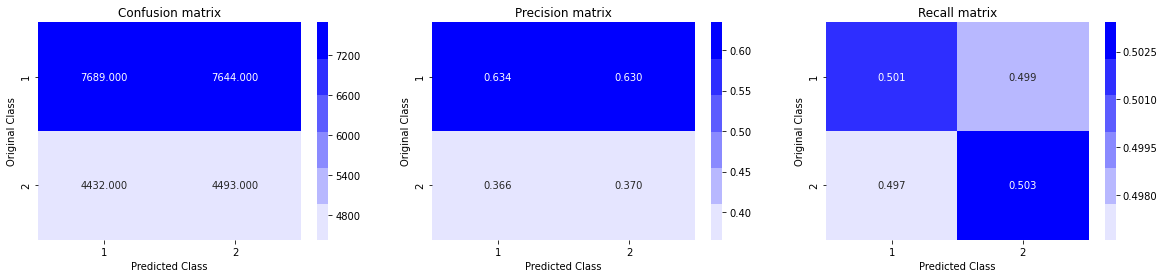

In [513]:
plot_confusion_matrix(y_test, predicted_y)

<p>note that in this confusion matrix function
- class 0= class 1= not duplicate 
- class 1=class 2= duplicate
</p>

<h2> 11. Logistic Regression with hyperparameter tuning </h2>

In [515]:
alpha = [10 ** x for x in range(-3, 3)] # hyperparam for SGD classifier

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

log_loss_train=[] #log loss for different hyperparams on train dataset
log_loss_cv=[] #log loss for different hyperparams on cv dataset

#in this problem instead of accuracy and error we will do cross validation based on log loss

for i in tqdm(alpha): 
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(x_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train, y_train)
    predict_x_train_prob = sig_clf.predict_proba(x_train) #this function of calibration gives an array with elements of size (1,2) which have close to real prob of class 0 and class 1
    predict_x_cv_prob = sig_clf.predict_proba(x_cv) 
    train_log_loss=log_loss(y_train, predict_x_train_prob, eps=1e-15) #train log loss
    cv_log_loss=log_loss(y_cv, predict_x_cv_prob, eps=1e-15) #cv log loss
    log_loss_train.append(train_log_loss)
    log_loss_cv.append(cv_log_loss)
    

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [05:26<00:00, 54.34s/it]


In [516]:
print(log_loss_cv)

[0.6589080824731194, 0.6589080824731194, 0.6589080824731194, 0.6171731891902184, 0.6190466400285374, 0.6139439656860237]


In [517]:
print("the best hyperparameter value: ")
print(alpha[log_loss_cv.index(min(log_loss_cv))])

the best hyperparameter value: 
100


final test log loss on the best tuned hyperparameter: 
0.6086713267202869


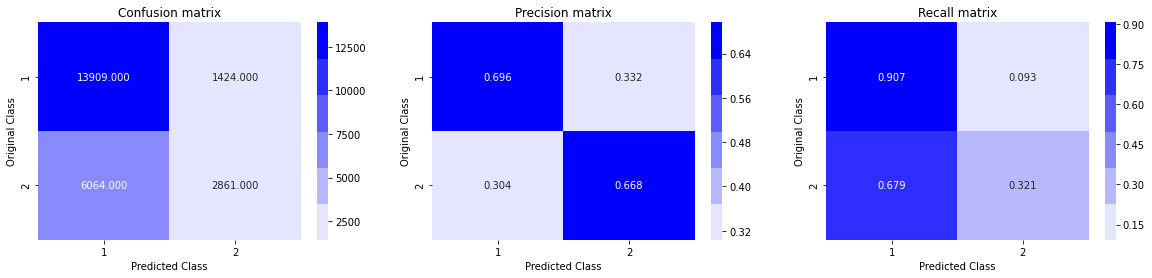

In [538]:
#training with the best hyperparam value
clf = SGDClassifier(alpha=100, penalty='l2', loss='log', random_state=42)
clf.fit(x_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train, y_train)

predict_x_test_prob = sig_clf.predict_proba(x_test) #this function of calibration gives an array with elements of size (1,2) which have close to real prob of class 0 and class 1
log_loss_test=log_loss(y_test, predict_x_test_prob, eps=1e-15) #test log loss

print("final test log loss on the best tuned hyperparameter: ")
print(log_loss_test)

#printing the confusion matrix
predicted_y =np.argmax(predict_x_test_prob, axis=1) #gives the predicted class as 0 or 1 (returns index with larger value)
plot_confusion_matrix(y_test, predicted_y)



<h2> 11. Linear SVM with hyperparameter tuning </h2>


In [531]:
alpha = [10 ** x for x in range(-3, 3)] # hyperparam for Linear SVM classifier

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

log_loss_train=[] #log loss for different hyperparams on train dataset
log_loss_cv=[] #log loss for different hyperparams on cv dataset

#in this problem instead of accuracy and error we will do cross validation based on log loss

for i in tqdm(alpha): 
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(x_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train, y_train)
    predict_x_train_prob = sig_clf.predict_proba(x_train) #this function of calibration gives an array with elements of size (1,2) which have close to real prob of class 0 and class 1
    predict_x_cv_prob = sig_clf.predict_proba(x_cv) 
    train_log_loss=log_loss(y_train, predict_x_train_prob, eps=1e-15) #train log loss
    cv_log_loss=log_loss(y_cv, predict_x_cv_prob, eps=1e-15) #cv log loss
    log_loss_train.append(train_log_loss)
    log_loss_cv.append(cv_log_loss)
    

 83%|█████████████████████████████████████████████████████████████████████▏             | 5/6 [08:50<01:47, 107.93s/it]C:\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [11:29<00:00, 114.99s/it]


In [533]:
print(log_loss_train)
print(log_loss_cv)

[0.6583023216976455, 0.6583023216976455, 0.6583023216976455, 0.6583023216976455, 0.5852945239406572, 0.6294349039966426]
[0.6589080824731194, 0.6589080824731194, 0.6589080824731194, 0.6589080824731194, 0.5898879883586108, 0.6299119940364034]


In [535]:
print("the best hyperparameter value: ")
print(alpha[log_loss_cv.index(min(log_loss_cv))])

the best hyperparameter value: 
10


final test log loss on the best tuned hyperparameter: 
0.582100044192091


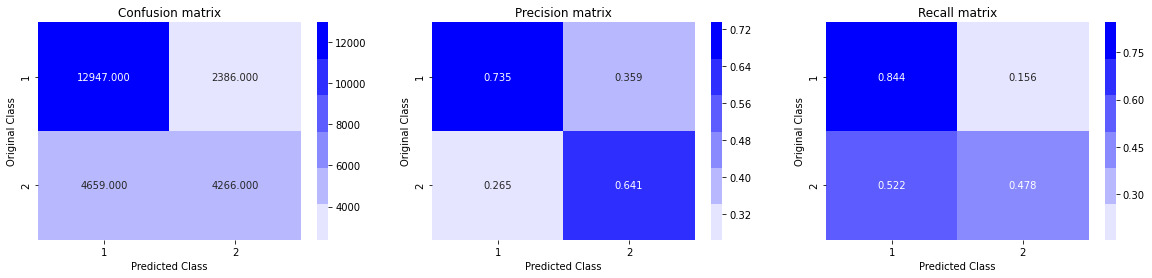

In [539]:
#training with the best hyperparam value
clf = SGDClassifier(alpha=10, penalty='l1', loss='hinge', random_state=42)
clf.fit(x_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train, y_train)

predict_x_test_prob = sig_clf.predict_proba(x_test) #this function of calibration gives an array with elements of size (1,2) which have close to real prob of class 0 and class 1
log_loss_test=log_loss(y_test, predict_x_test_prob, eps=1e-15) #test log loss

print("final test log loss on the best tuned hyperparameter: ")
print(log_loss_test)

#printing the confusion matrix
predicted_y =np.argmax(predict_x_test_prob, axis=1) #gives the predicted class as 0 or 1 (returns index with larger value)
plot_confusion_matrix(y_test, predicted_y)



<h2> 12. XGBoost </h2>

In [544]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(x_train, label=y_train)
d_test = xgb.DMatrix(x_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(x_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.68595	valid-logloss:0.68594
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.62672	valid-logloss:0.62650
[20]	train-logloss:0.58384	valid-logloss:0.58360
[30]	train-logloss:0.55174	valid-logloss:0.55153
[40]	train-logloss:0.52696	valid-logloss:0.52685
[50]	train-logloss:0.50702	valid-logloss:0.50702
[60]	train-logloss:0.49102	valid-logloss:0.49112
[70]	train-logloss:0.47820	valid-logloss:0.47846
[80]	train-logloss:0.46764	valid-logloss:0.46808
[90]	train-logloss:0.45878	valid-logloss:0.45952
[100]	train-logloss:0.45127	valid-logloss:0.45237
[110]	train-logloss:0.44470	valid-logloss:0.44628
[120]	train-logloss:0.43905	valid-logloss:0.44106
[130]	train-logloss:0.43397	valid-logloss:0.43639
[140]	train-logloss:0.42932	valid-logloss:0.43218
[150]	train-logloss:0.42535	valid-logloss:0.42872
[160]	train-logloss:0.42176	valid-logloss:0.42571
[170]	trai

Total number of data points : 24258


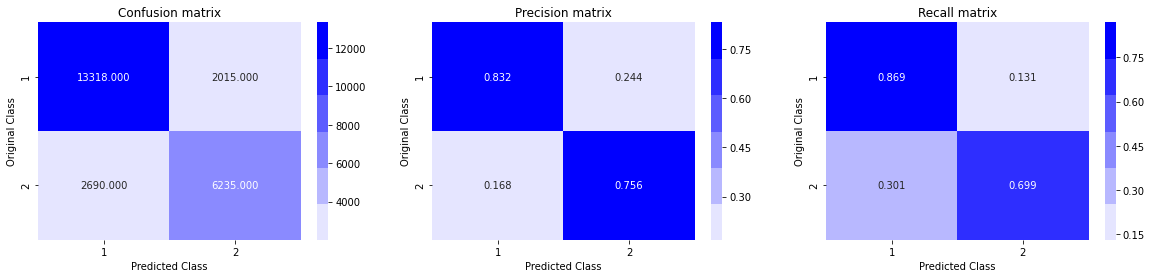

In [545]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 13. Result </h2>

<p> The XGBoost Model performed the best and gave a log loss of 0.394 </p>